In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.float_format', lambda x: '%.3f' % x)  #nustatom tasku funkcija ir desimtainiu skaiciu po kablelio Pandoje.

data = pd.read_pickle('butai.pkl')


data = data[data['City'] == 'Vilnius']  #nusistatom miesta = Vilnius

data = data[data['Price'] < 300_000]

data = data[data['Year'] > 1880]


#nusistatom koordinates kaip x ir y vertes.
def get_x(coords):    
    if coords is None:
        return None
    return coords[0]

def get_y(coords):
    if coords is None:
        return None
    return coords[1]

data['x'] = data['Coordinates'].apply(get_x)
data['y'] = data['Coordinates'].apply(get_y)

target = 'Price'

In [2]:
data.head()

,_id,Price,Address,Phone,Broker,Coordinates,Reserved,Date_scraped,Description,Misc,...,Buto_numeris,Uploaded,Edited,Saved,Viewed,Active_until,Renovation_year,Unikalus_daikto_numeris_(RC_numeris),x,y
0,1-3331147,212900,"Vilnius, Baltupiai, Ozo g.",,True,"[54.715901, 25.281605]",False,2023-07-15 14:01:30,\n YPATINGAS PASIŪLYMAS! Tik li...,"[Nauja kanalizacija, Nauja elektros instaliaci...",...,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,54.716,25.282
1,1-3319293,186000,"Vilnius, Pašilaičiai, Sviliškių g.",+370 614 99096,True,"[54.731977, 25.215925]",False,2023-07-15 14:01:36,\n ATVIRŲ DURŲ DIENOS nuo liepo...,"[Virtuvė sujungta su kambariu, Balkonas, Vonia...",...,82,2023-04-28,2023-07-14,46.000,5690.000,NaT,NaN,NaN,54.732,25.216
2,1-3302599,139000,"Vilnius, Pašilaičiai, Budiniškių g.",,True,"[54.730654, 25.211805]",False,2023-07-15 14:01:41,\n Liko paskutinis butas projek...,"[Nauja kanalizacija, Nauja elektros instaliaci...",...,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,54.731,25.212
3,1-3312509,129100,"Vilnius, Lazdynėliai, Lietaus g.",,True,"[54.662312, 25.189535]",False,2023-07-15 14:01:48,\n ❗❗ Susipažinkite - tai - ger...,"[Nauja kanalizacija, Nauja elektros instaliaci...",...,A2-7,NaT,NaT,NaN,NaN,NaT,NaN,NaN,54.662,25.190
4,1-3315825,140600,"Vilnius, Lazdynėliai, Lazdynėlių g.",+370 661 02828,True,"[54.659997, 25.192264]",False,2023-07-15 14:01:57,"\n LAZDYNĖLIŲ G. 57, KVARTALE P...","[Nauja kanalizacija, Nauja elektros instaliaci...",...,NaN,2023-07-11,2023-07-11,36.000,398.000,NaT,NaN,NaN,54.660,25.192


In [3]:
pd.DataFrame(data.dtypes) #pasiziurim kokios reiksmes atitinka kokias vertes (skaitines, kategorines, data)

,0
_id,object
Price,int64
Address,object
Phone,object
Broker,bool
Coordinates,object
Reserved,bool
Date_scraped,datetime64[ns]
Description,object
Misc,object


In [4]:
#pasidarom skaitiniu ir kategoriniu reiksmiu sarasus

num_cols = list(data.select_dtypes(include='number').columns)
cat_cols = set(data.columns) - set(num_cols)

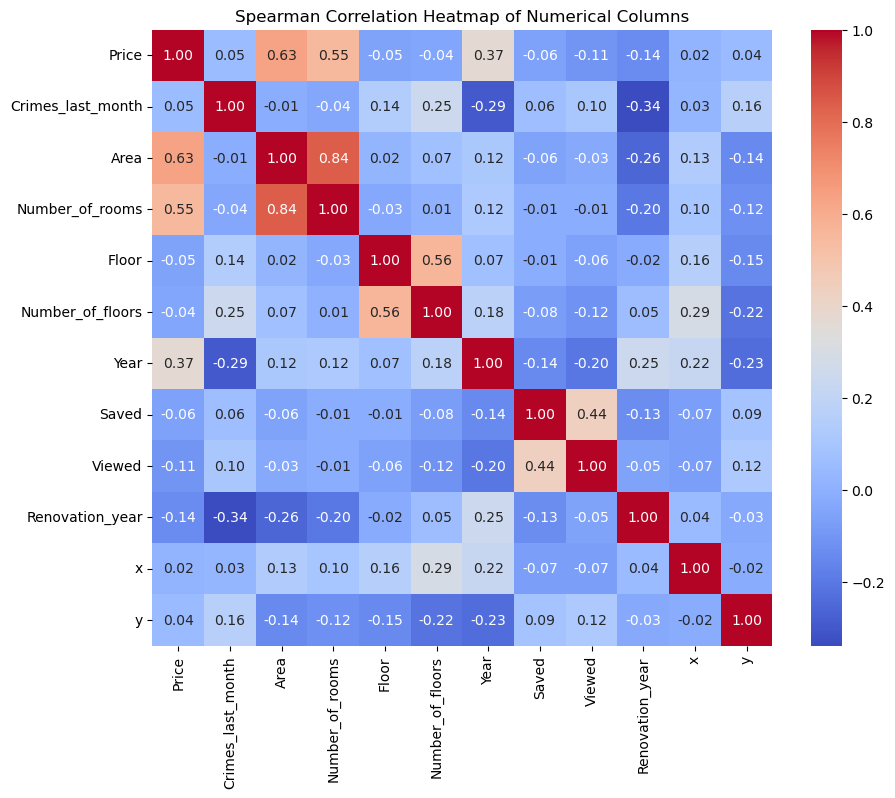

In [5]:
#atvaizduojam skaitiniu reiksmiu lapa, nurodanti labiausiai koreliuojancias reiksmes

corr_matrix = data[num_cols].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Heatmap of Numerical Columns')
plt.show()

In [6]:
pd.DataFrame(abs(corr_matrix['Price']).sort_values(ascending=False)) #pasiziurim 'abs'oliucias vertes is anksciau panaudodotos matricos mazejancia tvarka.

,Price
Price,1.000
Area,0.632
Number_of_rooms,0.547
Year,0.371
Renovation_year,0.137
Viewed,0.108
Saved,0.058
Floor,0.053
Crimes_last_month,0.050
Number_of_floors,0.044


In [7]:
#pasidarom sarasa stulpeliu, kurie labiausiai koreliuoja su "Price" stulpeliu ir nustatom koreliacijos koeficienta > 0.3.

highly_correlated_columns = list(corr_matrix[abs(corr_matrix['Price']).sort_values(ascending=False) > 0.3].index)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2876\3422942155.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highly_correlated_columns = list(corr_matrix[abs(corr_matrix['Price']).sort_values(ascending=False) > 0.3].index)


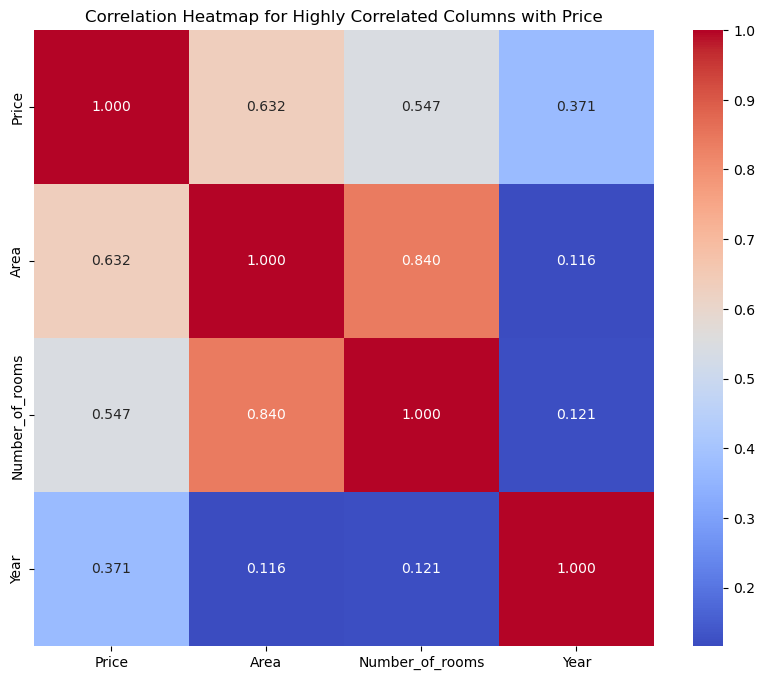

In [8]:
# Creating a subset of the correlation matrix for highly correlated columns
correlation_subset = corr_matrix.loc[highly_correlated_columns, highly_correlated_columns]

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Heatmap for Highly Correlated Columns with Price')
plt.show()

Vizualine Skaitiniu duomenu analize:

<function matplotlib.pyplot.show(close=None, block=None)>

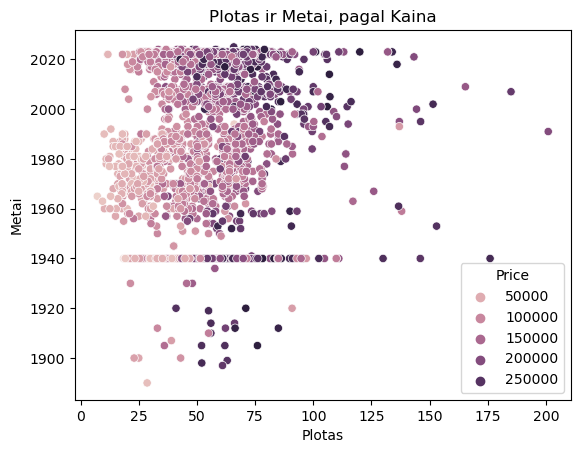

In [9]:
#Kainos santykis pagal dvi labiausiai koreliuojancias reiksmes. Ploto ir Metu(sakom, kad Plotas ir kambariu skaiciai = sinonimas).
# Lapas nera labai informatyvus del didelio reiksmiu kiekio, bet galime pasidaryti kelias isvadas:
#didziausia kaina turi naujos statybos namai. Kainos dydis priklauso nuo didejancio ploto. 
#statybos metai nuo 1950 iki 2000 turi vidutines kainos vertes.

sns.scatterplot(data, x='Area', y='Year', hue='Price')
plt.xlabel('Plotas')
plt.ylabel('Metai')
plt.title('Plotas ir Metai, pagal Kaina')
plt.show

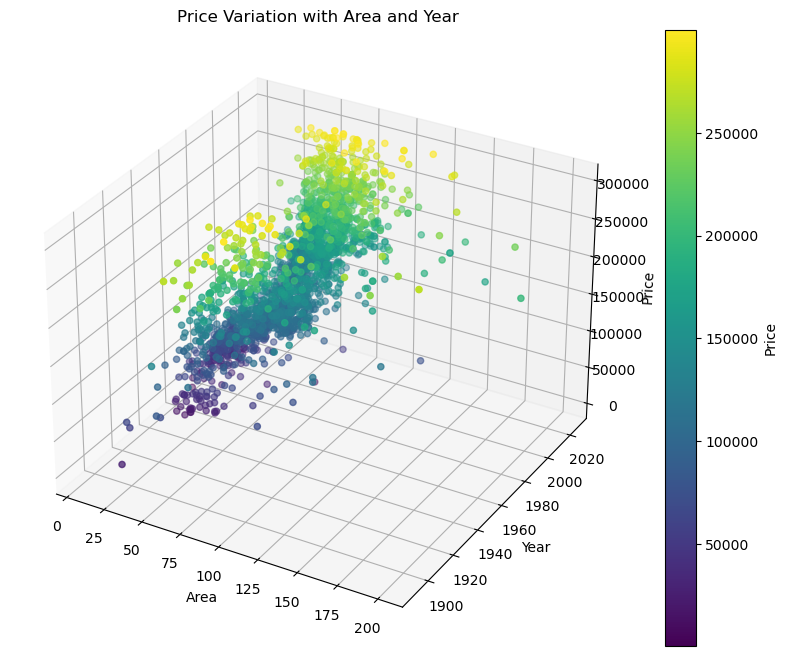

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data['Area'], data['Year'], data['Price'], c=data['Price'], cmap='viridis', marker='o')
ax.set_xlabel('Area')
ax.set_ylabel('Year')
ax.set_zlabel('Price')
plt.title('Price Variation with Area and Year')

cbar = fig.colorbar(scatter)
cbar.set_label('Price')

plt.show()

#is lapo galime pamatyti didziausias reiksmiu diapazonas yra melynam ir zydram spektre. Tai butu nuo 2000 metu statybos, kaina apie 100-150.000. Bendrai, naujesnes statybos namai turi didesne kainos verte.

Vizualine Kategoriniu reiksmiu analize:

In [11]:
#is adresu stulpelio pasiimam rajono reiksme ir nurodom ja atskiram stulpelyje 'District'
addresses_split = data['Address'].str.split(',', expand=True)
district = addresses_split[1]
data['District'] = district

In [12]:
data['District'].value_counts()

District
 Naujamiestis          234
 Šnipiškės             185
 Senamiestis           164
 Pašilaičiai           160
 Pilaitė               144
 Žirmūnai              139
 Antakalnis            125
 Justiniškės           125
 Lazdynėliai           102
 Naujininkai            96
 Karoliniškės           86
 Naujoji Vilnia         81
 Šeškinė                77
 Viršuliškės            71
 Fabijoniškės           70
 Žvėrynas               59
 Baltupiai              58
 Lazdynai               58
 Bajorai                54
 Jeruzalė               40
 Užupis                 39
 Šiaurės miestelis      32
 Santariškės            31
 Markučiai              28
 Paupys                 24
 Grigiškės              23
 Žemieji Paneriai       22
 Vilkpėdė               15
 Burbiškės              15
 Rasos                  11
 Kalnėnai               11
 Tarandė                10
 Visoriai                9
 Valakampiai             9
 Paneriai                9
 Pavilnys                8
 Verkiai           

In [13]:
data = data[~data['District'].isin(['Turniškės', 'Buivydiškės', ' Kirtimai', 'Saulėtekis'])] #atsisakom rajonu su nurodytom reiksmem(del mazu rodikliu)

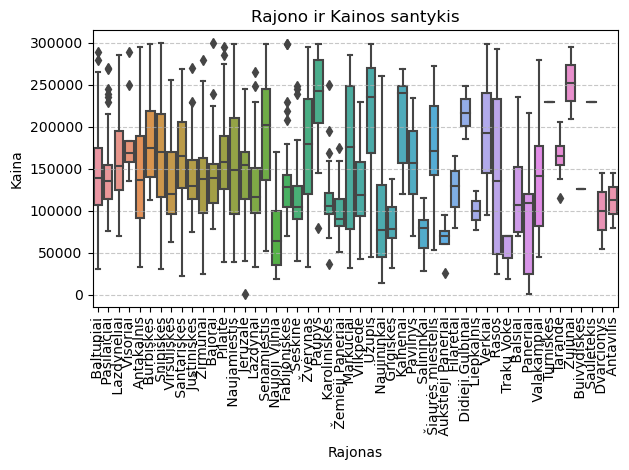

In [14]:
sns.boxplot(data, x='District', y='Price')
plt.title('Rajono ir Kainos santykis')
plt.xlabel('Rajonas')
plt.ylabel('Kaina')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#ISVADOS: Gana sunkiai iziurimas lapas del daugelio reiksmiu. Vistik galime pamatyti skirtingus rajonus turincius skirtingas kainu tendencijas pvz. kad Zujunai, Tarande ar Paupio rajonai islaiko gana aukstas
# kainas ir kainu vidurki (virs 200.000), o Naujosios Vilnios, Aukstuju Paneriu ar Salininku rajonai turi zemiausias rinkos kainas su maziausiais vidurkiais (60-70.000).
#Pagal daugiausiai parduodamu butu ir kainos santyki (40-50m2, apie 100-120.000, zr. zemiau pateiktose lentelese) mineti rajonai net nepatenka i sia kategorija. Vienu kainos nesiekia, kitu daug aukstesnes.
#Drasiai galima tvirtinti, kad  vietove itakoja kainu rodiklius.

In [15]:
average_price = data.groupby('District')['Price'].mean()
total_price = data.groupby('District')['Price'].sum()

average_price_df = pd.DataFrame({'District': average_price.index, 'Average Price': average_price.values})
total_price_df = pd.DataFrame({'District': total_price.index, 'Total Price': total_price.values})


average_price_df.sort_values(by='Average Price', inplace=True)
total_price_df.sort_values(by='Total Price', inplace=True, ascending=False)

average_price_df.reset_index(drop=True, inplace=True)
total_price_df.reset_index(drop=True, inplace=True)


print("Average Price sorted by District (ascending):\n", average_price_df)
print("\nTotal Price sorted by District (descending):\n", total_price_df)

#lenteleje matom kainu vidurki pagal rajona ir bendra parduodamu butu suma. Didziausia parduodamu butu kainos Suma yra Naujamiescio, Senamiescio ir Snipiskiu raj.(Manomai tai nurodo rajonu populiaruma ir verte investuojant)

Average Price sorted by District (ascending):
                District  Average Price
0            Trakų Vokė      52866.667
1    Aukštieji Paneriai      65580.000
2        Naujoji Vilnia      72250.617
3            Salininkai      73071.429
4             Grigiškės      85643.478
5              Paneriai      89593.889
6           Naujininkai      93182.479
7      Žemieji Paneriai      99954.545
8            Liepkalnis     100000.000
9            Dvarčionys     100000.000
10         Karoliniškės     110169.628
11              Šeškinė     111114.818
12            Antavilis     112500.000
13             Vilkpėdė     121931.867
14            Filaretai     125000.000
15          Buivydiškės     125500.000
16             Lazdynai     127230.793
17              Balsiai     127800.000
18         Fabijoniškės     130904.571
19             Žirmūnai     133512.777
20          Viršuliškės     133651.775
21          Justiniškės     137634.448
22          Pašilaičiai     139347.444
23              B

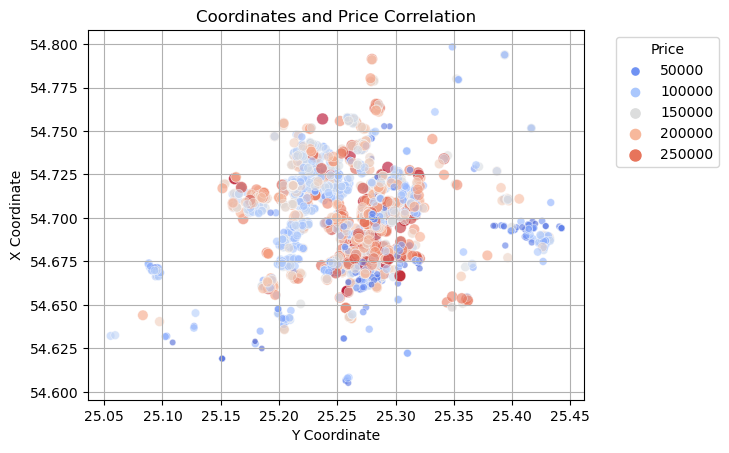

In [16]:
# Scatter plot with adjusted color and size mappings
sns.scatterplot(data=data, x='y', y='x', hue='Price', size='Price', palette='coolwarm', alpha=0.6)
plt.title('Coordinates and Price Correlation')
plt.xlabel('Y Coordinate')
plt.ylabel('X Coordinate')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#Lenteleje yra atvaizduotas realus zemelapis su kainom. Didziausia koncentracija matoma centriniuose miesto rajonuose. cia butu kainos salyginai aukstesnes. 

Trukstamu Reiksmiu Datos koregavimas ir nereikalingu duomenu salinimas

<Axes: >

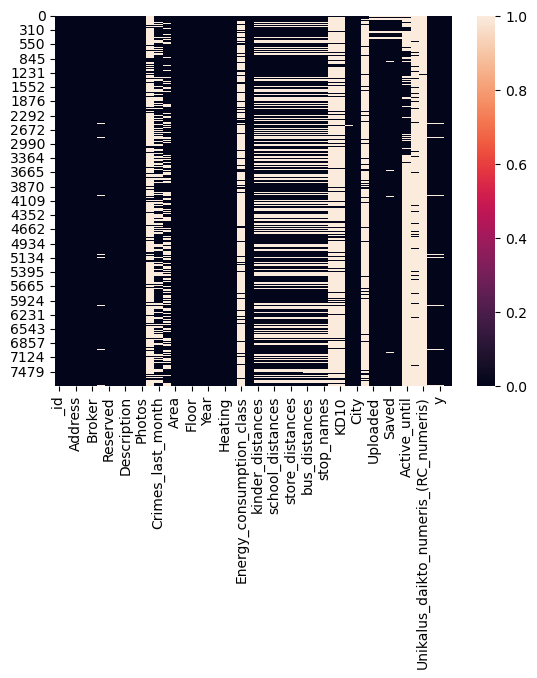

In [17]:
sns.heatmap(data.isna())
#vizualinis trukstamu reiksmiu pavyzdys

In [18]:
#pasidarom 'ismetamu' kintamuju sarasa
drop_cols = ['Buto_numeris', 'Uploaded', 'Edited', 'Saved',	'Viewed', 'Photos', 'Active_until', 'Renovation_year', 'Unikalus_daikto_numeris_(RC_numeris)', '_id', 'Phone', 'Reserved', 'Date_scraped', 'Description', 'store_names', 'bus_names', 'stop_names', 'NO2', 'KD10', 'Thumbnail']
data.drop(drop_cols, axis=1, inplace=True)


data.dropna(axis=1, thresh = int(0.75*data.shape[0]), inplace=True) #jeigu  nuliniu verciu skaicius stulpelyje bus didesnis nei 75%, stulpelis bus eliminuotas
num_cols = list(data.select_dtypes(include='number').columns) #sudaromas skaitiniu duomenu sarasas
cat_cols = ['Building_type', 'Heating', 'Furnishing'] #nurodomas konkretus kategoriniu duomenu sarasas

data = data[num_cols + cat_cols]  
data.columns

Index(['Price', 'Area', 'Number_of_rooms', 'Floor', 'Number_of_floors', 'Year',
       'x', 'y', 'Building_type', 'Heating', 'Furnishing'],
      dtype='object')

In [19]:
data.head()

,Price,Area,Number_of_rooms,Floor,Number_of_floors,Year,x,y,Building_type,Heating,Furnishing
0,212900,67.410,3,3,7,2022,54.716,25.282,Mūrinis,Centrinis kolektorinis,Įrengtas
1,186000,64.480,4,2,5,2023,54.732,25.216,Mūrinis,Centrinis kolektorinis,Įrengtas
2,139000,51.340,3,7,7,2022,54.731,25.212,Mūrinis,Centrinis kolektorinis,Dalinė apdaila
3,129100,43.000,2,2,4,2023,54.662,25.190,Mūrinis,Centrinis kolektorinis,Dalinė apdaila
4,140600,44.730,2,1,4,2022,54.660,25.192,Mūrinis,Centrinis kolektorinis,Įrengtas


In [20]:
data[num_cols].fillna((data[num_cols]).mean(), inplace=True) #uzpildo skaitines reiksmes trukstamose stulpeliu reiksmese su reiksmiu vidurkiu 
data[cat_cols].fillna((data[cat_cols]).mode(), inplace=True) #kategorines reiksmes su dazniausiai pasikartojancia reiksme

data.dropna(inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2876\295691103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[num_cols].fillna((data[num_cols]).mean(), inplace=True) #uzpildo skaitines reiksmes trukstamose stulpeliu reiksmese su reiksmiu vidurkiu
C:\Users\Admin\AppData\Local\Temp\ipykernel_2876\295691103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat_cols].fillna((data[cat_cols]).mode(), inplace=True) #kategorines reiksmes su dazniausiai pasikartojancia reiksme


Kategoriniu reiksmiu analize 2:


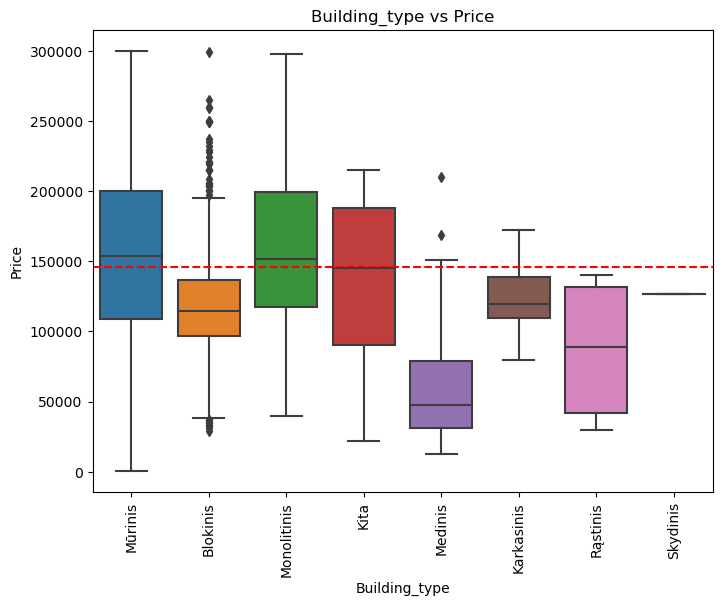

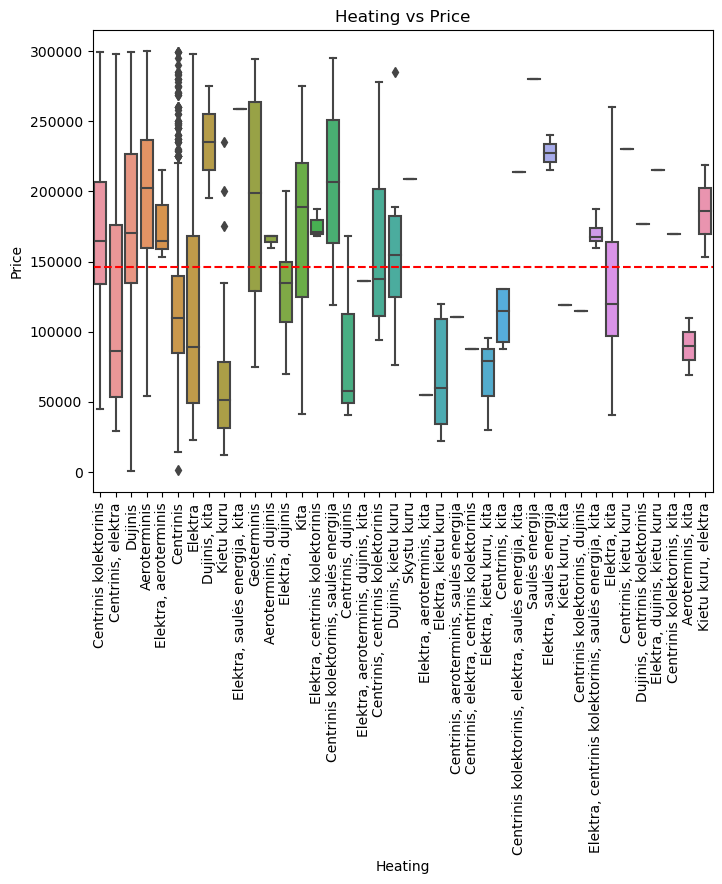

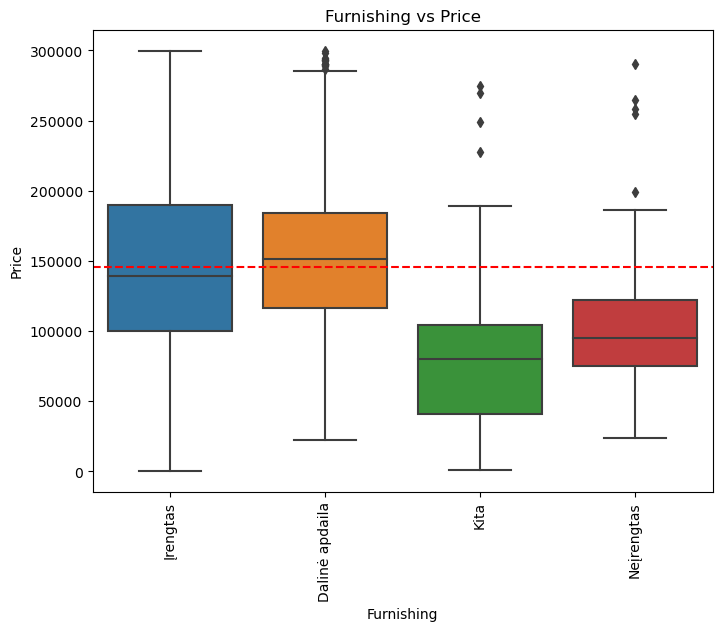

In [21]:
for col in cat_cols:
    plt.figure(figsize=(8, 6)) 
    plt.title(f'{col} vs {target}')
    sns.boxplot(data=data, x=col, y=target)
    plt.axhline(y=data[target].mean(), color='red', linestyle='--')
    plt.xticks(rotation=90) 
    plt.show()


#zemiau nurodytose lentelese galima pamatyti kainu variacijas pagal kainu vidurki pazymeta raudona linija
#pirmoje lenteleje pamatome, kad monolitiniai ar muriniai namai turi didziausias kainas. Mediniai maziausiai vertinami.
#antroje matome, kad modernus sildymo sprendimai turi didesne verte nei senieji(pvz. Geoterminis vs. Kietu kuru).
#Trecioje lenteleje matome, kad irengti ar daline apdaila butai turi didesne kaina nei neirengti.

Nutolusiu reiksmiu tvarkymas:

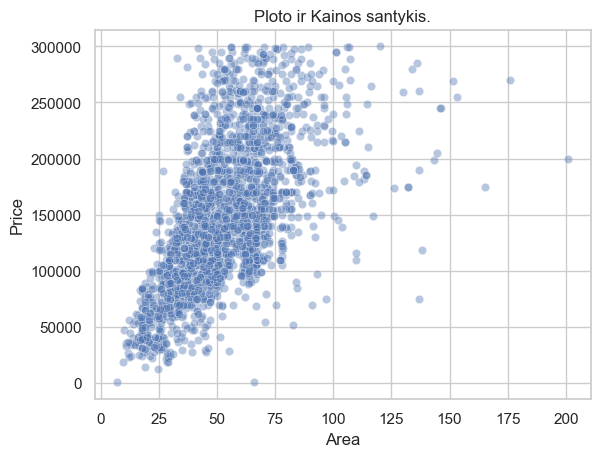

In [22]:
sns.set(style="whitegrid")

sns.scatterplot(data, x='Area', y='Price', alpha = 0.4)
plt.title('Ploto ir Kainos santykis.')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()


# pasiziurim bendra jau nustatytu verciu spektra. Matome, kad butai didesnio, nei 100 m2 ploto iskrenta is didziausio verciu susiburimo.
# Kadangi tokios pavienes vertes stipriai iskreipia duomenu rodiklius, ju zadame atsisakyti.

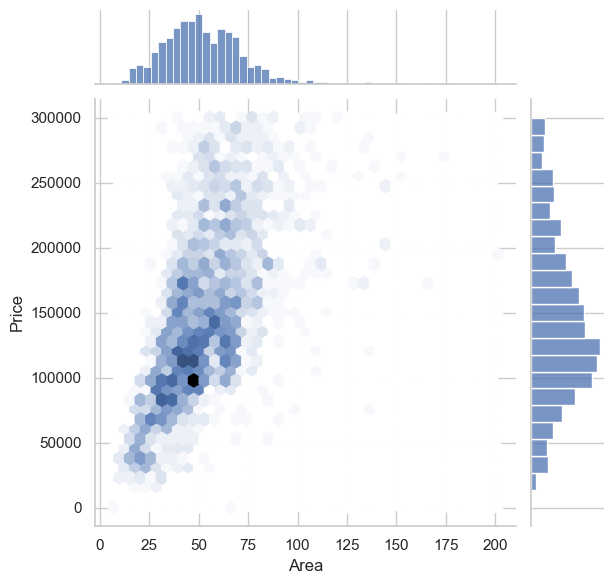

In [23]:
sns.jointplot(data, x='Area', y='Price', kind='hex')

In [24]:
data = data[data['Area'] < 105]
data = data[data['Area'] > 10]
data = data[data['Price'] > 40_000]
#nustatom naujas ribas 

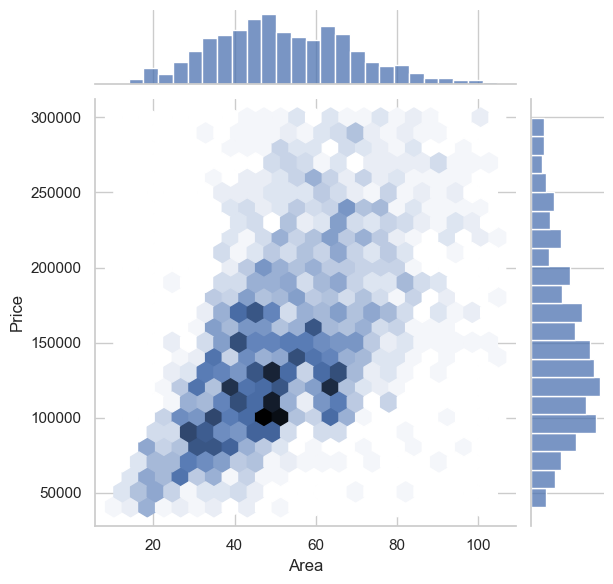

In [25]:
sns.jointplot(data, x='Area', y='Price', kind='hex')

#is lapo su naujai nustatytom vertem galime pamatyti, kad didziausias kiekis reiksmiu tenka ploto diapazone 40-50m2 ir kainu 100-150.000EUR

Pritaikymas ir Ivertinimas pagal CatBoostRegressor modeli:

In [26]:
X = data.drop(target, axis=1)
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = CatBoostRegressor(cat_features=cat_cols, verbose=0, random_seed=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


result_data = X_test
result_data['real_price']  = y_test
result_data['predicted_price'] = y_pred
result_data['predicted_price'] = result_data['predicted_price'].astype(int)

#naudojamas CatBoost Regressor modelis ispeti kainas testiniame variante. 

In [27]:
result_data.head()

,Area,Number_of_rooms,Floor,Number_of_floors,Year,x,y,Building_type,Heating,Furnishing,real_price,predicted_price
4379,48.500,2,9,12,1978,54.709,25.220,Blokinis,Centrinis,Įrengtas,110000,105694
6113,39.460,2,3,4,2020,54.662,25.192,Mūrinis,Centrinis kolektorinis,Įrengtas,148000,145850
1779,63.430,2,3,3,1956,54.647,25.210,Mūrinis,Elektra,Įrengtas,88300,122009
566,52.050,2,6,7,2022,54.669,25.254,Mūrinis,Centrinis kolektorinis,Įrengtas,227000,216227
2080,40.000,2,2,3,1940,54.681,25.290,Mūrinis,Centrinis,Įrengtas,225000,183029


In [28]:
np.sqrt(mean_squared_error(y_test, y_pred))
# Vidutinis spejimu nuokrypis nuo tikruju verciu.

21021.099719917718

In [29]:
mean_absolute_error(y_test, y_pred) 
#absoliutus vidurkio skirtumas tarp tikruju  ir spejamuju verciu. Maziau jautrus nukrypusiom vertem del to geresnis nei RMSE

15210.894648249008

In [30]:
mean_absolute_percentage_error(y_test, y_pred)
#vidutinis klaidu dydis procentais

0.11982104386703

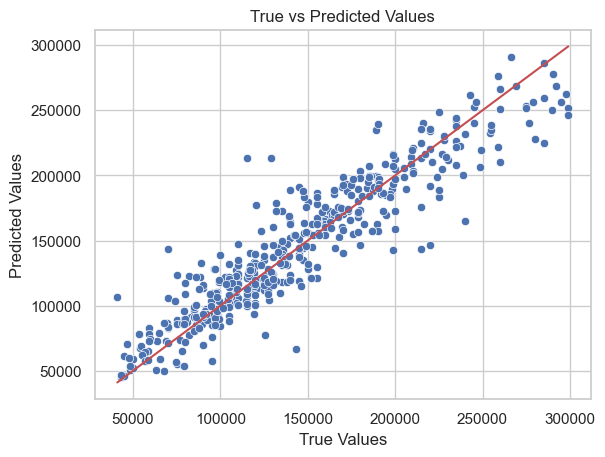

In [31]:
sns.scatterplot(x=y_test, y=y_pred)

# Add diagonal line representing perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

In [32]:
result_data['absolute_percentage_error'] = abs(result_data['predicted_price'] - result_data['real_price']) / result_data['real_price']

result_data['absolute_percentage_error'].describe()

#sis kodas generuoja aprasomasias statistikas - absoliucia procentine paklaida

count   460.000
mean      0.120
std       0.139
min       0.000
25%       0.040
50%       0.085
75%       0.157
max       1.601
Name: absolute_percentage_error, dtype: float64

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


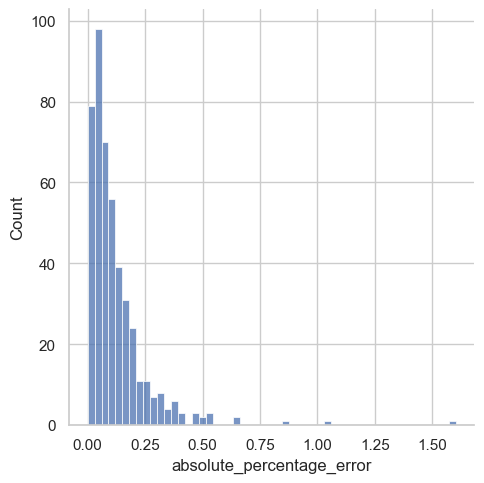

In [33]:
sns.displot(result_data, x='absolute_percentage_error')
#vizualinis paklaidos atvaizdavimas, parodantis kad didziaja dali modelio paklaidu sudaro maziausios vertes.

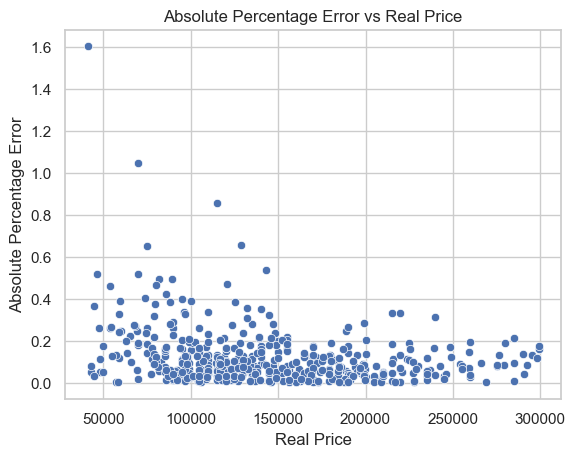

In [38]:
sns.scatterplot(data=result_data, x='real_price', y='absolute_percentage_error')

plt.xlabel('Real Price')
plt.ylabel('Absolute Percentage Error')
plt.title('Absolute Percentage Error vs Real Price')
plt.show()

#cia matome tikru kainu ir procentines paklaidos santyki. yra vienetiniu nuokrypiu, bet didzioji dauguma spejimu neiseina is 0.2 % paklaidos. 
#Taip pat matome, kad didzioji dauguma didesnes nei 0.2 paklaidos dalis priklauso kainu spektrui iki 150.000